Hello guys, lately i've been studying about machine translation and give it a try. Most of code in this notebook is based on tensorflow tutorial on their website, you can find it [here](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt). 
# English - Japanese Machine Translation
So in this notebook we're going to build English to Japanese machine translation, Japanese text contains lots of unique words because they have 3 type of it:
1. Kanji
1. Katakana
1. Hiragana

thats the insteristing part of it and so it'll be little complicated to process. So let's get started.

# Table Of Content
1. Load Dataset
1. Text Preprocessing
    1. English missplell handling
    1. Segmentating Japanese words
    1. Add BOS and EOS to train sentences
1. Word Tokenizing
    1. Word Cloud
1. Build & Train Model
1. Scoring Bleu
1. Test with Some Raw Input

## Install some tools
1. Sacreblue for calculate BLEU score
1. Googletrans => Google Translate for testing some sentences later

Note : You can use NLTK for calculating BLEU score [documentation](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)

In [1]:
!pip -q install sacrebleu
!pip -q install googletrans
!pip -q install tensorflow-addons --upgrade

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import random, re, string, itertools, timeit, sacrebleu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split

# Tensorflow & Keras
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, LSTM, LSTMCell
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Japanese Word Tokenizer
from janome.tokenizer import Tokenizer as janome_tokenizer

plt.style.use('seaborn-pastel')

# Dataset
Here we use 55463 en-jp corpus from multiple source

1. ManyThings.org Bilingual Sentence Pairs<br>
-> Official Site : [Here](http://www.manythings.org/bilingual/)<-

In [3]:
# Download Data & Unzip Data
!wget http://www.manythings.org/anki/jpn-eng.zip
!unzip jpn-eng.zip

--2020-08-19 01:52:31--  http://www.manythings.org/anki/jpn-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2303148 (2.2M) [application/zip]
Saving to: ‘jpn-eng.zip’

jpn-eng.zip         100%[===================>]   2.20M  9.70MB/s    in 0.2s    

2020-08-19 01:52:32 (9.70 MB/s) - ‘jpn-eng.zip’ saved [2303148/2303148]

Archive:  jpn-eng.zip
  inflating: jpn.txt                 
  inflating: _about.txt              


Load data to memory.

In [4]:
data = []

f1 = open('./jpn.txt', 'r')
data += [x.rstrip().lower().split('\t')[:2] for x in tqdm(f1.readlines())]
f1.close()

print(f'Loaded {len(data)} Sentences')


Loaded 53594 Sentences


# Text Preprocessing
### Handling misspell words & Clearing Punctuation
we're gonna change the misspell words in english sentences and clearing punctuation from text.

"aren't my english bad?" -> "are not my english bad"

In [5]:
mispell_dict = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "i would",
    "i'd" : "i had",
    "i'll" : "i will",
    "i'm" : "i am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "i have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying"
}

mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))

def preprocess(text) -> str:
    def replace(match):
        return mispell_dict[match.group(0)]
    
    text = mispell_re.sub(replace, text)
    return text

Japanese words have their own punctuation like 【this】

In [6]:
# Adding Japanese Punctuation
string.punctuation += '、。【】「」『』…・〽（）〜？！｡：､；･'

CP = lambda x : x.translate(str.maketrans('', '', string.punctuation))

In [7]:
data = [x for x in data if len(x) == 2]

eng_data = [CP(preprocess(x[0])) for x in data]
jpn_data = [CP(x[1]) for x in data]

### Segmentating Japanese Sentences
Unlike english sentence we can tokenize it by splitting words with space just like this,
```
'This is english or i think so'.split()

Output:
['This', 'is', 'english', 'or', 'i', 'think', 'so']
```
but in Japanese we can't do it that way. Here we gonna use Janome Tokennizer to segmentating Japanese sentence and adding space to it so Keras Tokenizer can handle it.

In [8]:
# Initialize Janome Tokenizer
token_jp = janome_tokenizer()

In [9]:
sample_text = 'ここで私は英語で話している'
' '.join([word for word in token_jp.tokenize(sample_text, wakati=True) \
          if word != ' '])

'ここ で 私 は 英語 で 話し て いる'

In [10]:
# Apply to Japanese Sentences
jpn_data = [' '.join([word for word in token_jp.tokenize(x, wakati=True) \
                      if word != ' ']) for x in tqdm(jpn_data)]

For evaluating our model let's split our data.

In [11]:
eng_train, eng_test, jpn_train, jpn_test = \
train_test_split(eng_data, jpn_data, test_size = 0.04, random_state = 42)

print(f"Splitting to {len(eng_train)} Train data and \
{len(eng_test)} Test data")

Splitting to 51450 Train data and 2144 Test data


### Add BOS and EOS
We put BOS "Begin of Sequence" and EOS “End of Sequence" to help our decoder recognize begin and end of a sequance.

In [12]:
eng_train = ['bos '+ x + ' eos' for x in eng_train + ['unk unk unk']]
jpn_train = ['bos '+ x + ' eos' for x in jpn_train + ['unk unk unk']]

eng_val = ['bos '+ x + ' eos' for x in eng_test]
jpn_val = ['bos '+ x + ' eos' for x in jpn_test]

# Word Tokenizing
Here we use Tokenizer API from Keras to make vocabulary and tokenizing our data

In [13]:
# English Tokenizer
en_tokenizer = Tokenizer(filters='')
en_tokenizer.fit_on_texts(eng_train)

# Japannese Tokenizer
jp_tokenizer = Tokenizer(filters='')
jp_tokenizer.fit_on_texts(jpn_train)

In [14]:
print(f'English vocab size   :', len(en_tokenizer.word_index) - 3)
print(f'Japanese vocab size  :', len(jp_tokenizer.word_index) - 3)

English vocab size   : 9646
Japanese vocab size  : 14403


## Word Cloud
What comes when doing NLP? It's Word Cloud. Let's do it for our vocab.

Font : [Google Noto Fonts](https://www.google.com/get/noto/) -> Noto Sans CJK JP

In [15]:
!wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!wget https://raw.githubusercontent.com/Hyuto/NMT-TF-Seq2seq-EN-JP/master/Japan.jpg
!wget https://raw.githubusercontent.com/Hyuto/NMT-TF-Seq2seq-EN-JP/master/English.png
!mkdir font
!unzip NotoSansCJKjp-hinted.zip -d ./font

--2020-08-19 01:53:52--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121096772 (115M) [application/zip]
Saving to: ‘NotoSansCJKjp-hinted.zip’

NotoSansCJKjp-hinte 100%[===================>] 115.49M  53.3MB/s    in 2.2s    

2020-08-19 01:53:54 (53.3 MB/s) - ‘NotoSansCJKjp-hinted.zip’ saved [121096772/121096772]

--2020-08-19 01:53:55--  https://raw.githubusercontent.com/Hyuto/NMT-TF-Seq2seq-EN-JP/master/Japan.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [16]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

def get_words(arr):
    keys = list(arr.keys())
    count = list(arr.values())
    return ' '.join([x for _,x in sorted(zip(count, keys), reverse = True)][2:])

def transform(arr):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            if not any(arr[i][j]):
                arr[i][j] = np.array([225, 225, 225, 225])
    return arr

font_path = './font/NotoSansCJKjp-Light.otf'


mask = './English.png'
mask = np.array(Image.open(mask))
mask = transform(mask)
image_colors = ImageColorGenerator(mask)
words = get_words(en_tokenizer.word_counts).title()
wc = WordCloud(background_color="white", max_words=2000, random_state=42,
               width=mask.shape[1], height=mask.shape[0])
wc = wc.generate(words)
fig1, ax1 = plt.subplots(figsize=(20,15))
ax1.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
ax1.axis("off")

mask = './Japan.jpg'
mask = np.array(Image.open(mask))
image_colors = ImageColorGenerator(mask)
words = get_words(jp_tokenizer.word_counts).title()
wc = WordCloud(collocations=False, background_color="white", mode="RGBA", 
               max_words=6000, font_path=font_path, contour_width=1, 
               scale=5, max_font_size = 50, relative_scaling=0.5, 
               random_state=42, width=mask.shape[1], height=mask.shape[0])
wc = wc.generate(words)
fig2, ax2 = plt.subplots(figsize=(20,15))
ax2.imshow(wc.recolor(color_func=image_colors), interpolation='bilinear')
ax2.axis("off")

fig1.savefig('WC_English.png')
fig2.savefig('WC_Japanese.png')
plt.close(fig1)
plt.close(fig2)

!rm -rf ./font

In [17]:
# @hidden_cell
%%HTML

<head>
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <style>
        body {font-family: Arial;}
        img {max-width:100%; height:auto}
        .tab {
          overflow: hidden;
          border: 1px solid #ccc;
          background-color: #f1f1f1;
        }
        .tab button {
          background-color: #5ECF57;
          float: left;
          border: none;
          outline: none;
          cursor: pointer;
          padding: 14px 16px;
          transition: 0.3s;
          font-size: 17px;
        }
        .tab button:hover {
          background-color: #48C768;
        }
        .tab button.active {
          background-color: #48C768;
        }
        .tabcontent {
          display: none;
          padding: 6px 12px;
          border: 1px solid #ccc;
          border-top: none;
        }
    </style>
</head>
<body>
    <h2>Word Cloud</h2>
    <p>Click on the buttons inside the tabbed menu</p>

    <div class="tab">
        <button class="tablinks" onclick="openCity(event, 'English')">English</button>
        <button class="tablinks" onclick="openCity(event, 'Japanese')">Japanese</button>
    </div>

    <div id="English" class="tabcontent">
        <h3>English</h3>
        <p>English Vocabulary WordCloud</p>
        <img src="./WC_English.png" alt="WC_English.png">
    </div>

    <div id="Japanese" class="tabcontent">
        <h3>Japanese</h3>
        <p>Japanese Vocabulary WordCloud</p>
        <img src="./WC_Japanese.png" alt="WC_Japanese.png">
    </div>

    <script>
    function openCity(evt, cityName) {
      var i, tabcontent, tablinks;
      tabcontent = document.getElementsByClassName("tabcontent");
      for (i = 0; i < tabcontent.length; i++) {
        tabcontent[i].style.display = "none";
      }
      tablinks = document.getElementsByClassName("tablinks");
      for (i = 0; i < tablinks.length; i++) {
        tablinks[i].className = tablinks[i].className.replace(" active", "");
      }
      document.getElementById(cityName).style.display = "block";
      evt.currentTarget.className += " active";
    }
    </script>
   
</body>

now let's transform our train sentences to sequences.

In [18]:
def Sequences(texts, tokenizer):
    res = []
    for text in texts:
        seq = []
        for w in text.split():
            try:
                seq.append(tokenizer.word_index[w])
            except:
                seq.append(tokenizer.word_index['unk'])
        res.append(seq)
    return res

In [19]:
# Transform Sentences to Sequences
data_en = en_tokenizer.texts_to_sequences(eng_train)
data_jp = jp_tokenizer.texts_to_sequences(jpn_train)

val_en = Sequences(eng_val, en_tokenizer)
val_jp = Sequences(jpn_val, jp_tokenizer)

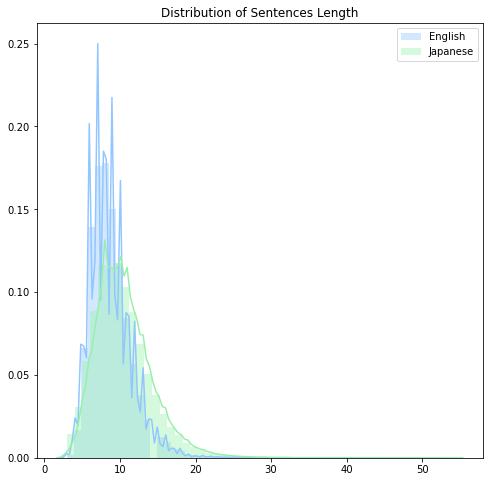

In [20]:
plt.figure(figsize = (8,8))
sns.distplot([len(x) for x in data_en], label='English')
sns.distplot([len(x) for x in data_jp], label='Japanese')
plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

based on the distplot English sentences contains about 20 - 40 words while Japanese have more wider range. 

Let's check their max lenght

In [21]:
max_en = max([len(x) for x in data_en] + [len(x) for x in val_en])
max_jp = max([len(x) for x in data_jp] + [len(x) for x in val_jp])

print(f'Maximum length of English sequences is  {max_en}')
print(f'Maximum length of Japanese sequences is {max_jp}')

Maximum length of English sequences is  49
Maximum length of Japanese sequences is 54


In [22]:
# Padding Sequences
data_en = pad_sequences(data_en, padding='post', maxlen = max_en)
data_jp = pad_sequences(data_jp, padding='post', maxlen = max_jp)

val_en = pad_sequences(val_en, padding='post', maxlen = max_en)
val_jp = pad_sequences(val_jp, padding='post', maxlen = max_jp)

# Build & Train Model
Now it's the time brace yourself.

We'll build model based on Seq2seq approaches with Attention optimization.
> Seq2Seq is a method of encoder-decoder based machine translation that maps an input of sequence to an output of sequence with a tag and attention value. The idea is to use 2 RNN that will work together with a special token and trying to predict the next state sequence from the previous sequence.

![Seq2Seq](https://raw.githubusercontent.com/Hyuto/NMT-TF-Seq2seq-EN-JP/master/Seq2Seq.png)

In [23]:
# Config
epochs = 7
BATCH_SIZE = 64
BUFFER_SIZE = len(data_jp)
steps_per_epoch = BUFFER_SIZE//BATCH_SIZE
val_steps_per_epoch = len(val_jp) // BATCH_SIZE
embedding_dims = 256
rnn_units = 1024
dense_units = 1024
Dtype = tf.float32

In [24]:
def max_len(tensor):
    """
    Get max len in Sequences
    """
    return max( len(t) for t in tensor)

In [25]:
# Max Len
Tx = max_len(data_en)
Ty = max_len(data_jp)

# Vocab
input_vocab_size = len(en_tokenizer.word_index) + 1   # English
output_vocab_size = len(jp_tokenizer.word_index) + 1  # Japanese

# Changging to TF data
dataset = (tf.data.Dataset.from_tensor_slices((data_en, data_jp))
           .shuffle(BUFFER_SIZE)
           .batch(BATCH_SIZE, drop_remainder=True)
          )

val_dataset = (tf.data.Dataset.from_tensor_slices((val_en, val_jp))
               .batch(BATCH_SIZE)
              )

Let's define our based Seq2Seq Model

In [26]:
#ENCODER
class EncoderNetwork(tf.keras.Model):
    def __init__(self,input_vocab_size,embedding_dims, rnn_units ):
        super().__init__()
        self.encoder_embedding = Embedding(input_dim=input_vocab_size,
                                           output_dim=embedding_dims)
        self.encoder_rnnlayer = LSTM(rnn_units,return_sequences=True,
                                     return_state=True )
    
#DECODER
class DecoderNetwork(tf.keras.Model):
    def __init__(self,output_vocab_size, embedding_dims, rnn_units):
        super().__init__()
        self.decoder_embedding = Embedding(input_dim=output_vocab_size,
                                           output_dim=embedding_dims) 
        self.dense_layer = Dense(output_vocab_size)
        self.decoder_rnncell = LSTMCell(rnn_units)
        # Sampler
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        # Create attention mechanism with memory = None
        self.attention_mechanism = \
            self.build_attention_mechanism(dense_units,None,BATCH_SIZE*[Tx])
        self.rnn_cell = self.build_rnn_cell(BATCH_SIZE)
        self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell,
                                                sampler= self.sampler,
                                                output_layer = self.dense_layer
                                               )

    def build_attention_mechanism(self, units, memory, MSL):
        """
        MSL : Memory Sequence Length
        """
        #return tfa.seq2seq.LuongAttention(units, memory = memory, 
        #                                  memory_sequence_length = MSL)
        return tfa.seq2seq.BahdanauAttention(units, memory = memory, 
                                             memory_sequence_length = MSL)

    # wrap decodernn cell  
    def build_rnn_cell(self, batch_size):
        return tfa.seq2seq.AttentionWrapper(self.decoder_rnncell, 
                                            self.attention_mechanism,
                                            attention_layer_size=dense_units)
    
    def build_decoder_initial_state(self, batch_size, encoder_state, Dtype):
        decoder_initial_state = self.rnn_cell.get_initial_state(batch_size = batch_size, 
                                                                dtype = Dtype)
        decoder_initial_state = decoder_initial_state.clone(cell_state = encoder_state) 
        return decoder_initial_state

In [27]:
# Build Model
encoderNetwork = EncoderNetwork(input_vocab_size, embedding_dims, rnn_units)
decoderNetwork = DecoderNetwork(output_vocab_size, embedding_dims, rnn_units)

# Optimizer
optimizer = tf.keras.optimizers.Adam()

Make custom training loop

In [28]:
def loss_function(y_pred, y):
    #shape of y [batch_size, ty]
    #shape of y_pred [batch_size, Ty, output_vocab_size] 
    sparsecategoricalcrossentropy = SparseCategoricalCrossentropy(from_logits=True,
                                                                  reduction='none')
    loss = sparsecategoricalcrossentropy(y_true=y, y_pred=y_pred)
    mask = tf.logical_not(tf.math.equal(y,0))   #output 0 for y=0 else output 1
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = mask * loss
    loss = tf.reduce_mean(loss)
    return loss

@tf.function
def train_step(input_batch, output_batch, encoder_initial_cell_state):
    # initialize loss = 0
    loss = 0
    with tf.GradientTape() as tape:
        encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
        a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                        initial_state = encoder_initial_cell_state)

        # [last step activations,last memory_state] of 
        # encoder passed as input to decoder Network
         
        # Prepare correct Decoder input & output sequence data
        decoder_input = output_batch[:,:-1] # ignore eos
        # compare logits with timestepped +1 version of decoder_input
        decoder_output = output_batch[:,1:] #ignore bos

        # Decoder Embeddings
        decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

        # Setting up decoder memory from encoder output 
        # and Zero State for AttentionWrapperState
        decoderNetwork.attention_mechanism.setup_memory(a)
        decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                           encoder_state=[a_tx, c_tx],
                                                                           Dtype=tf.float32)
        
        # BasicDecoderOutput        
        outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                               sequence_length=BATCH_SIZE*[Ty-1])

        logits = outputs.rnn_output
        
        # Calculate loss
        loss = loss_function(logits, decoder_output)

    # Returns the list of all layer variables / weights.
    variables = encoderNetwork.trainable_variables + decoderNetwork.trainable_variables  
    # differentiate loss wrt variables
    gradients = tape.gradient(loss, variables)

    # grads_and_vars – List of(gradient, variable) pairs.
    grads_and_vars = zip(gradients,variables)
    optimizer.apply_gradients(grads_and_vars)
    return loss

@tf.function
def evaluate(input_batch, output_batch, encoder_initial_cell_state):
    loss = 0
    encoder_emb_inp = encoderNetwork.encoder_embedding(input_batch)
    a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp, 
                                                    initial_state =encoder_initial_cell_state)
    decoder_input = output_batch[:,:-1]
    decoder_output = output_batch[:,1:]
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)
    decoderNetwork.attention_mechanism.setup_memory(a)
    decoder_initial_state = decoderNetwork.build_decoder_initial_state(BATCH_SIZE,
                                                                       encoder_state=[a_tx, c_tx],
                                                                       Dtype=tf.float32)
    outputs, _, _ = decoderNetwork.decoder(decoder_emb_inp,initial_state=decoder_initial_state,
                                           sequence_length=BATCH_SIZE*[Ty-1])
    logits = outputs.rnn_output
    loss = loss_function(logits, decoder_output)
    return loss

In [29]:
# RNN LSTM hidden and memory state initializer
def initialize_initial_state():
    return [tf.zeros((BATCH_SIZE, rnn_units)), tf.zeros((BATCH_SIZE, rnn_units))]

# Calculating BLEU Score
> BLEU (bilingual evaluation understudy) is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is". - Wikipedia

BLEU is a metric for evaluating a generated sentence to a reference sentence.
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.


So now we're going to define our translation function & calculate the BLEU score for test data at the end of every epoch while training. Note that test data is sentences that our tokenizer didn't train with, so there must be some words that our tokenizer didn't know. 
I'm currently working to fix this issue. Based on keras Tokenizer API it have `oov_token` for handling this but i'm not sure.

For now i'm handling this by adding `unk` in train dataset so the tokenizer can read it, and then when coming to translation if there is word that our tokenizer don't know i'll set it by index of `unk` not very eficient but it works.

In [30]:
# Translate
def Translate(input_raw):
    input_raw = CP(preprocess(input_raw))
    input_lines = ['bos '+ input_raw + '']
    
    input_sequences, unique = [], []
    for line in input_lines:
        temp = []
        for w in line.split(' '):
            try:
                temp.append(en_tokenizer.word_index[w])
            except: # Avoid Error
                unique.append(w)
                temp.append(en_tokenizer.word_index['unk'])
        input_sequences.append(temp)
    
    input_sequences = pad_sequences(input_sequences, maxlen=Tx, padding='post')
    inp = tf.convert_to_tensor(input_sequences)
    inference_batch_size = input_sequences.shape[0]
    encoder_initial_cell_state = [tf.zeros((inference_batch_size, rnn_units)),
                                  tf.zeros((inference_batch_size, rnn_units))]
    encoder_emb_inp = encoderNetwork.encoder_embedding(inp)
    a, a_tx, c_tx = encoderNetwork.encoder_rnnlayer(encoder_emb_inp,
                                                    initial_state = encoder_initial_cell_state)

    start_tokens = tf.fill([inference_batch_size], jp_tokenizer.word_index['bos'])

    end_token = jp_tokenizer.word_index['eos']

    greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

    decoder_input = tf.expand_dims([jp_tokenizer.word_index['bos']] * inference_batch_size,1)
    decoder_emb_inp = decoderNetwork.decoder_embedding(decoder_input)

    decoder_instance = tfa.seq2seq.BasicDecoder(cell = decoderNetwork.rnn_cell, 
                                                sampler = greedy_sampler,
                                                output_layer = decoderNetwork.dense_layer)
    decoderNetwork.attention_mechanism.setup_memory(a)

    decoder_initial_state = decoderNetwork.build_decoder_initial_state(
        inference_batch_size, encoder_state=[a_tx, c_tx], Dtype=tf.float32)

    maximum_iterations = tf.round(tf.reduce_max(Tx) * 2)

    decoder_embedding_matrix = decoderNetwork.decoder_embedding.variables[0] 
    (first_finished, first_inputs,first_state) = decoder_instance.initialize(
        decoder_embedding_matrix, start_tokens = start_tokens,
        end_token = end_token, initial_state = decoder_initial_state)

    inputs = first_inputs
    state = first_state  
    predictions = np.empty((inference_batch_size,0), dtype = np.int32)                                                              
    for j in range(maximum_iterations):
        outputs, next_state, next_inputs, finished = decoder_instance.step(j, inputs,state)
        inputs = next_inputs
        state = next_state
        outputs = np.expand_dims(outputs.sample_id,axis = -1)
        predictions = np.append(predictions, outputs, axis = -1)
        
    res = ''
    for i in range(len(predictions)):
        line = predictions[i,:]
        seq = list(itertools.takewhile(lambda index: index !=2, line))
        res += " ".join( [jp_tokenizer.index_word[w] for w in seq])
    res = res.split()
    
    # Return back Unique words
    for i in range(len(res)):
        if res[i] == 'unk' and unique != []:
            res[i] = unique.pop(0)
    
    return ' '.join(res)

# Calculate BLEU
def BLEU(X, y):
    # Prediction
    pred = [Translate(w) for w in tqdm(X)]
    # Calculate BLEU 
    score = sacrebleu.corpus_bleu(pred, [y]).score / 100
    return score, pred

In [31]:
# Custom Train Progress
class Progress:
    def __init__(self):
        self.fig = plt.figure(figsize = (8,6))
        self.ax = self.fig.add_subplot(1, 1, 1)
        self.loss, self.val_loss, self.BLEU = [], [], []
        self.epoch_loss = 0
        
    def get_val_loss(self):
        return [x[1] for x in self.val_loss]
        
    # Plot
    def dynamic_plot(self):
        self.ax.cla()
        self.ax.plot(range(len(self.loss)), self.loss, label='loss')
        if len(self.val_loss) >= 1:
            x = [l[0] for l in self.val_loss]
            y = [l[1] for l in self.val_loss]
            self.ax.plot(x, y, color = 'r', label='val_loss')
            self.ax.plot(x, self.BLEU, color = 'purple', label='BLEU')
        self.ax.set_ylim(0,)
        self.ax.legend(loc = 1)
        display(self.fig)
    
    # Train step progress
    def train_progress(self, epoch, step, steps_per_epoch, start):
        self.dynamic_plot()
        print(f'Working on Epoch {epoch}')
        print('[' + ('=' * int((step + 1) / steps_per_epoch * 60)).ljust(61, ' ') 
              + f']  {step + 1}/{steps_per_epoch} - loss : {round(self.epoch_loss / step, 4)}')
        print(f'Time per Step {round(timeit.default_timer() - start, 2)} s')
        
    def summary(self):
        loss = np.array_split(np.array(self.loss), len(self.val_loss))
        loss = [np.mean(x) for x in loss]
        val_loss = [x[1] for x in self.val_loss]
        df = pd.DataFrame({'Epochs' : range(1, len(val_loss) + 1), 'loss' : loss,
                           'val loss' : val_loss, 'BLEU' : self.BLEU})
        
        self.dynamic_plot()
        clear_output(wait = True)
        display(df)

,Epochs,loss,val loss,BLEU
0,1,0.755007,0.617767,0.033657
1,2,0.507803,0.467358,0.100527
2,3,0.366943,0.404535,0.169416
3,4,0.278531,0.382699,0.206622
4,5,0.220114,0.379538,0.223136
5,6,0.180076,0.384533,0.240543
6,7,0.152284,0.390775,0.256055


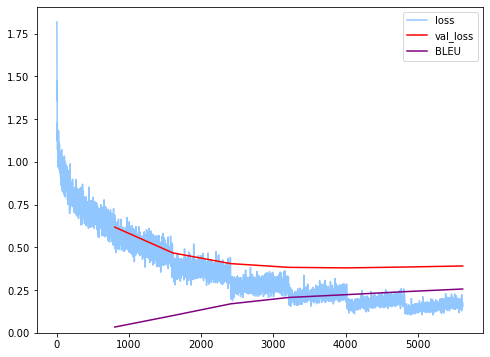

In [32]:
# Initialize Train Progress
TP = Progress()
best_prediction = []

for i in range(1, epochs + 1):

    encoder_initial_cell_state = initialize_initial_state()
    total_loss = 0.0
    # Train Loss
    TP.epoch_loss = 0

    # Train
    for (batch , (input_batch, output_batch)) in enumerate(dataset.take(steps_per_epoch)):
        start = timeit.default_timer()
        batch_loss = train_step(input_batch, output_batch, encoder_initial_cell_state)
        total_loss += batch_loss
        TP.loss.append(batch_loss.numpy())
        TP.epoch_loss += batch_loss.numpy()
            
        if (batch+1) % 30 == 0:
            TP.train_progress(i, batch, steps_per_epoch, start)
            clear_output(wait = True)
    
    # Validitate
    encoderNetwork.trainable = False  # Freeze our model layer to make sure
    decoderNetwork.trainable = False  # it didn't learn anything from val_data
    
    # Valid loss
    val_loss = 0
    for (batch, (input_batch, output_batch)) in enumerate(val_dataset.take(val_steps_per_epoch)):
        batch_loss = evaluate(input_batch, output_batch, encoder_initial_cell_state)
        val_loss += batch_loss.numpy()
    val_loss /= val_steps_per_epoch
    
    TP.val_loss.append((i * steps_per_epoch - 1, val_loss))
    
    # Bleu Score
    bleu_score, pred = BLEU(eng_test, jpn_test)
    TP.BLEU.append(bleu_score)
    
    encoderNetwork.trainable = True  # Unfreeze layer for next epoch
    decoderNetwork.trainable = True
    
    # Save best model
    if bleu_score == max(TP.BLEU) and val_loss == min(TP.get_val_loss()):
        best_prediction = pred
        encoderNetwork.save_weights('encoderNetwork')
        decoderNetwork.save_weights('decoderNetwork')

TP.summary()

In [33]:
# Load best weights
encoderNetwork.load_weights('encoderNetwork')
decoderNetwork.load_weights('decoderNetwork')

Let's check the best prediction of our model.

In [34]:
for i in range(7,16):
    print("English Sentence:")
    print(eng_test[i])
    print("\nJapanese Translation:")
    print(best_prediction[i])
    print("\nJapanese Reference:")
    print(jpn_test[i])
    print(''.ljust(60, '-'))

English Sentence:
in september there are just a few people here and there on the beach

Japanese Translation:
９ 時 に は ここ に 他 の 人 が 住ん で い ない 人 が その ビーチ で 他 の 人達 が 残り の もと を あちら に 建設 見 た

Japanese Reference:
９月 の 海 は 人 が まばら だ ね
------------------------------------------------------------
English Sentence:
while you are young you should read a lot

Japanese Translation:
若い 頃 は 読み 終わっ たら いい よ

Japanese Reference:
若い うち に たくさん の 本 を 読む べき だ
------------------------------------------------------------
English Sentence:
here i come

Japanese Translation:
ここ に 来 た の

Japanese Reference:
いま 行き ます
------------------------------------------------------------
English Sentence:
once you have decided when you will be coming let me know

Japanese Translation:
来る か 君 に は 連絡 を 言っ て き た よ

Japanese Reference:
いつ 来る か 決まっ たら 教え て
------------------------------------------------------------
English Sentence:
he jumped on the train

Japanese Translation:
彼 は 電車 に 旗 を 飛び越え た

Japanese Reference:
彼 は 電車 に 

# Test with Some Raw Input
Yeay now let's play with **our** Machine Translation with some raw input. We'll cross check the prediction from MT with Google Translate API to translate it back to english and see how bad **our** MT is :).

In [35]:
from googletrans import Translator
# Google Translate
translator = Translator()

In [36]:
raw_input = ['i love you', 'i am sorry', 'hello', 'thank you',
             'is there something i can help?']

for i in range(len(raw_input)):
    prediction = Translate(raw_input[i])
    print("English Sentence:")
    print(raw_input[i])
    print("\nJapanese Translation:")
    print(prediction)
    print("\nEnglish Translation from prediction [GoogleTranslate]:")
    print(translator.translate(prediction).text)
    print(''.ljust(60, '-'))

English Sentence:
i love you

Japanese Translation:
愛し てる よ

English Translation from prediction [GoogleTranslate]:
I love you
------------------------------------------------------------
English Sentence:
i am sorry

Japanese Translation:
すみません

English Translation from prediction [GoogleTranslate]:
Excuse me
------------------------------------------------------------
English Sentence:
hello

Japanese Translation:
もしもし

English Translation from prediction [GoogleTranslate]:
Hello
------------------------------------------------------------
English Sentence:
thank you

Japanese Translation:
ありがとう ござい ます

English Translation from prediction [GoogleTranslate]:
Thank you
------------------------------------------------------------
English Sentence:
is there something i can help?

Japanese Translation:
何 か 手伝える もの が ある の

English Translation from prediction [GoogleTranslate]:
There is something to help
------------------------------------------------------------


In [37]:
import pickle

with open('en_tokenizer.pickle', 'wb') as handle:
    pickle.dump(en_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

with open('jp_tokenizer.pickle', 'wb') as handle:
    pickle.dump(jp_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
handle.close()

## Thank you very much for reading my post
Please tell me when I make mistakes in program and English.
I hope this kernel will help and if you think this kernel is useful, please upvote.

# Reference
1. TensorFlow Addons Networks : Sequence-to-Sequence NMT with Attention Mechanism [Link](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt)
2. seq2seq (Sequence to Sequence) Model for Deep Learning with PyTorch [Link](https://www.guru99.com/seq2seq-model.html)